# Time series analysis as supervised learning

The remaining parts of the project will build models for time series data using Keras.

We will be using the mortgage affordability provided by Zillow https://www.zillow.com/research/data/ we have seen previously.

The project repository includes the data and utility functions to load and plot it

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import affordability_lib.utils as utils

afford_df = utils.get_affordability_df()
afford_df.head(10)

,RegionID,RegionName,SizeRank,1979-03,1979-06,1979-09,1979-12,1980-03,1980-06,1980-09,...,2014-12,2015-03,2015-06,2015-09,2015-12,2016-03,2016-06,2016-09,2016-12,2017-03
324,394913,"New York, NY",1,0.261700,0.278316,0.284399,0.319438,0.379845,0.318970,0.337586,...,0.241961,0.240494,0.247387,0.245957,0.249606,0.241544,0.239503,0.240021,0.265376,0.269264
325,753899,"Los Angeles-Long Beach-Anaheim, CA",2,0.357694,0.388161,0.401762,0.459422,0.541508,0.464528,0.486750,...,0.383162,0.382531,0.396277,0.395686,0.402116,0.393042,0.390708,0.386895,0.430334,0.433476
326,394463,"Chicago, IL",3,0.261928,0.276790,0.276248,0.309709,0.353099,0.299344,0.295616,...,0.134913,0.134063,0.139074,0.137962,0.138784,0.134412,0.133701,0.132856,0.147025,0.149054
327,394514,"Dallas-Fort Worth, TX",4,0.301131,0.328453,0.340857,0.386321,0.452818,0.376912,0.394715,...,0.118163,0.117663,0.124935,0.128167,0.133517,0.131539,0.133219,0.135142,0.149861,0.152387
328,394974,"Philadelphia, PA",5,0.204333,0.215107,0.219247,0.247690,0.295396,0.248018,0.260259,...,0.141915,0.139100,0.142831,0.141625,0.142089,0.137387,0.135599,0.135064,0.148746,0.148559
329,394692,"Houston, TX",6,0.243178,0.265630,0.268049,0.294382,0.342770,0.291661,0.292763,...,0.112149,0.113520,0.118255,0.119155,0.122370,0.120863,0.120717,0.120675,0.132078,0.130511
330,395209,"Washington, DC",7,0.254252,0.264869,0.277353,0.314773,0.373035,0.319475,0.337635,...,0.174821,0.173381,0.178910,0.177032,0.178584,0.172367,0.169965,0.168010,0.185774,0.186239
331,394856,"Miami-Fort Lauderdale, FL",8,0.267852,0.284229,0.287053,0.332037,0.392403,0.334098,0.360938,...,0.181766,0.183585,0.194088,0.197580,0.203430,0.197855,0.198292,0.199508,0.221129,0.222176
332,394347,"Atlanta, GA",9,0.248301,0.264578,0.271742,0.312490,0.371988,0.307385,0.322451,...,0.113326,0.113214,0.117454,0.118066,0.120754,0.117895,0.117187,0.116937,0.130104,0.131081
333,394404,"Boston, MA",10,0.222021,0.237248,0.239940,0.276893,0.316496,0.271210,0.285134,...,0.212892,0.210786,0.216809,0.217371,0.221722,0.215844,0.214103,0.212644,0.236357,0.239656


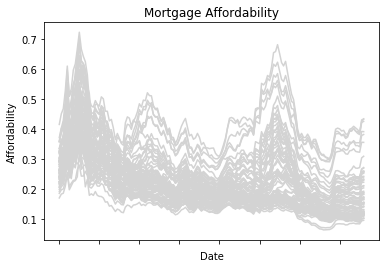

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
utils.plot_affordability_series(afford_df)
plt.show()

## Getting data ready

We will build models that forecast mortgage one-year-out affordability based on the previous 4 years of affordability values. To obtain data for model building we provide the class `TSExampleGenerator` in the `affordability_lib.utils` module. This class does a bunch of things so let's take a look by parts.

First, let's initialize the object. Here, we will set important parameters for our model building. We'll explain the parameters below

In [4]:
from affordability_lib.utils import TSExampleGenerator
example_generator_factory = TSExampleGenerator(afford_df, horizon=4, n_prediction_years=4,
                                      n_test_quarters = 4, n_val_quarters=4,
                                      normalize=True)


The parameters we pass have the following purpose:
- `afford_df`: the affordability data frame
- `horizon=4`: how far from the last observed timepoint do we make predictions, since we are making one-year-out predictions, we have a 4 quarter horizon
- `n_prediction_years`: how many years of data we use to make predictions, here we use 4 years, which gives us 16 total time points to use for predictions. Therefore, we have sequences of length 16, to make predictions of sequences of length 1
- `n_test_quarters`: we split the dataset into train, validation and test, here we specify that the **last four quarters** of data are to be used as targets for testing
- `n_val_quarters`: here we set that the four quarters preceeding the quarters above will be used as targets for validation, all the remaning data will be used for training
- `normalize`: standardize timeseries for each region by centering and scaling using region-specific mean and standard deviation. These parameters are computed from the training portion of the sequences only.

Once we have the object above we can get generators for the training, validation and testing portions of the dataset as follows:

In [5]:
# get generator for testing portion of dataset
test_generator, num_test_steps = example_generator_factory.get_test_gen(batchsize=20)
print(test_generator)
print(num_test_steps)

<generator object _example_generator at 0x7f8cc1f99e10>
15


The above states that `test_generator` is a python generator. These are objects we can use in iterations using the `next` keyword. For example, to get a batch of 20 test sequences I can do the following:

In [6]:
X, y = next(test_generator)
print(X.shape)
print(y.shape)

(20, 16, 1)
(20,)


Note that the shape of `X` has three dimensions because sequence models in keras require it. The first dimension is the number of sequences, the second dimension the number of steps in the sequence (time), and the third dimension the dimensionality of the observations at each timestep (here 1 since we only observe affordability, in other situations this could be a multidimensional vector).


The way this code is designed, we can call the `next` keyword on these generators infinitely as it is easier to use within keras that way. The `num_test_steps` returned above is used to ensure that we generate enough examples to cycle through at least once through the corresponding portion of the dataset. For instance, the following loop generates all test examples in the dataset.

In [7]:
for i in range(num_test_steps):
    X, y = next(test_generator)

## Baseline model

To get a sense of the problem, let's use a baseline model that uses average mortgage affordability over the previous four years to predict one-year-out affordability. Let's try this model on the validation dataset and compute it's median absolute error.

In [8]:
import numpy as np

def evaluate_naive():
    batch_maes = []
    gen, num_steps = example_generator_factory.get_val_gen(batchsize=20)
    for step in range(num_steps):
        X, y = next(gen)
        yhat = np.mean(X, axis=1)
        mae = np.median(np.abs(y - yhat))
        batch_maes.append(mae)
    return batch_maes

naive_maes = evaluate_naive()
print(np.mean(naive_maes))
print(np.std(naive_maes))

0.27454311314151586
0.05348667369435827


## Model building

Let's build a few models for this task using keras. For all of these use `RMSprop` as the gradient descent algorithm, and `median absolute error` as the loss function. For each of the model plot training and validation error across epochs and comment on their behavior. Is the model learning anything, is it overfitting, how stable is it, etc. For each model, report median absolute error on the validation set.

### Model 1: Linear Regression 

Train a linear regression model using Keras for this task.

- Recall that for linear regression we want to build a model

$$
f = Xw + b
$$ 

where in this case, $X$ will be a matrix with 16 columns, corresponding to the values of affordability for the previous four years.

The first layer in your network will be a `Flatten` layer since this is not a sequence model. This is true of the next two models as well. 

The general structure of your models will be as follows:

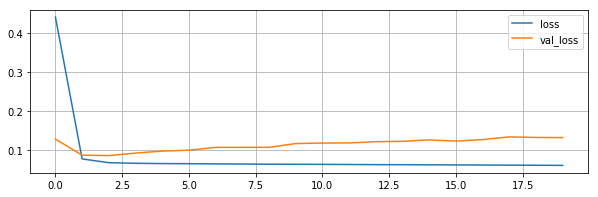

In [163]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(16,1)))
model.add(layers.Dense(1, input_shape=(16,1), activation='linear')) # linear regression

model.compile(optimizer=RMSprop(), loss='mae')
    
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps, verbose=False)

# you can use history to make plots of training and validation error
# after that you can make predictions with model.predict

plt.figure(figsize=(10,3))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.grid(True)
plt.legend()

In [161]:
# calculate mean error
#def evaluate_err(yhat):
#    # return median absolute error median(y-yhat) for each batch
#    batch_maes = []
#    gen, num_steps = example_generator_factory.get_val_gen(batchsize=20)
#    for step in range(num_steps):
#        X, y = next(gen)
#        mae = np.median(np.abs(y - yhat[i*20:(i+1)*20]))
#        batch_maes.append(mae)
#    return batch_maes

#yhat = model.predict_generator(val_gen, steps=num_val_steps, verbose=False)

#linreg_maes = evaluate_err(yhat)
#print(np.mean(linreg_maes))
#print(np.std(linreg_maes))

Better than the naive model as the mae loss goes down to < 0.1

### Model 2: Single Layer Feed-Forward Neural Network

Train a single layer feed forward neural network using Keras.

Don't worry about tuning parameters yet (i.e., the number of units in the hidden layer units). Choose a number and go with it.


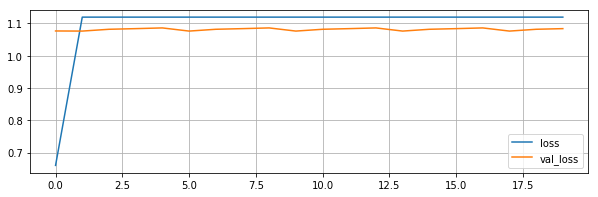

In [177]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(16,1)))
model.add(layers.Dense(1, activation='relu')) # hidden layer

model.compile(optimizer=RMSprop(), loss='mae')
    
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps, verbose=False)

# you can use history to make plots of training and validation error
# after that you can make predictions with model.predict

plt.figure(figsize=(10,3))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.grid(True)
plt.legend()

### Model 3: Deep Neural Network

Train a neural network with one or more layers for this task. 

Here, try tuning parameters (the number of hidden layers, and the number of units per layer). Use MAE on validation set as a guide.

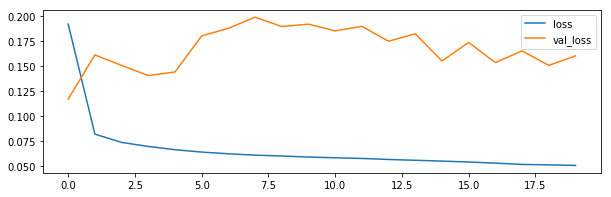

In [178]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(16,1)))
model.add(layers.Dense(64, activation='relu')) # single hidden layers
model.add(layers.Dense(16, activation='relu')) # single hidden layers
model.add(layers.Dense(23, activation='sigmoid')) # single hidden layers
model.add(layers.Dense(1, activation='linear')) # single hidden layers

model.compile(optimizer=RMSprop(), loss='mae')
    
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps, verbose=False)

# you can use history to make plots of training and validation error
# after that you can make predictions with model.predict

plt.figure(figsize=(10,3))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

Can't really get much of an improvement here. I tried various layers and sizes.

### Model 4: Single layer recurrent neural network

Train a recurrent neural network with a single layer, using a `GRU` recurrent cell. 

Look at documentation for the GRU layers in keras: https://keras.io/layers/recurrent/

You will not need a `Flatten` layer in these networks.

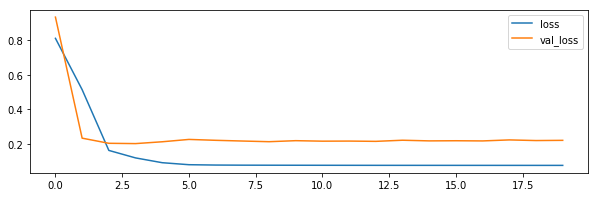

In [182]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(1, activation='linear', input_shape=(16,1))) # single hidden layers

model.compile(optimizer=RMSprop(), loss='mae')
    
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps, verbose=False)

# you can use history to make plots of training and validation error
# after that you can make predictions with model.predict

plt.figure(figsize=(10,3))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

### Model 5: Single layer recurrent neural network with dropout

Train a recurrent neural network with a single layer, using a GRU recurrent cell.

Look at documentation for the GRU layers in keras: https://keras.io/layers/recurrent/

Use the `dropout` and `recurrent_dropout` arguments to implement weight dropout in the RNN. 

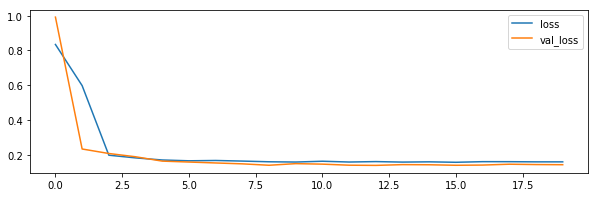

In [187]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(1, activation='linear', input_shape=(16,1), dropout=0.1, recurrent_dropout=0.1)) # single hidden layers

model.compile(optimizer=RMSprop(), loss='mae')
    
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps, verbose=False)

# you can use history to make plots of training and validation error
# after that you can make predictions with model.predict

plt.figure(figsize=(10,3))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

### Model 6: Deep RNN 

Train a recurrent neural network with two or more layers, with or without dropout. Here experiment with number and size of layers using validation error as a guide.

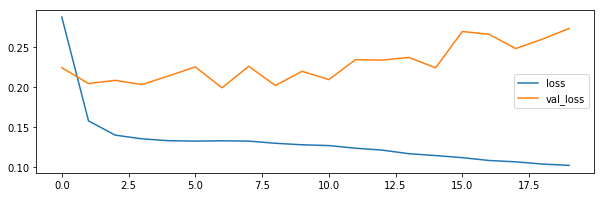

In [188]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(8, activation='linear', input_shape=(16,1), dropout=0.3, recurrent_dropout=0.3)) # single hidden layers
model.add(layers.Dense(6, activation='relu')) # single hidden layers
model.add(layers.Dense(4, activation='linear')) # single hidden layers
model.add(layers.Dense(1, activation='linear')) # single hidden layers

model.compile(optimizer=RMSprop(), loss='mae')
    
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps, verbose=False)

# you can use history to make plots of training and validation error
# after that you can make predictions with model.predict

plt.figure(figsize=(10,3))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

## Conclusion

Comment on the overall performance of these models. 

- How much of an improvement did you obtain over the baseline? 
- What is the general relative performance of recurrent networks relative to flat networks? 
- What was the effect of using dropout in the RNN network? 
- What was the effect of network architecture, number and size of layers, on performance? Was the effect similar in RNNs and flat networks?

Choose a final model based on your observations above and compare to the baseline model based on the median absolute error on the test set portion of the data. 

The Deep neural network seemed to do the best in reducing the mae loss. In this specific example recurrent networks seem to do worse than flat networks. Using dropout in the RNN seem to make things worse. The mae loss grew with the dropout. It is hard to find an optimization for number of layers/size; a result was found tweaking by hand.

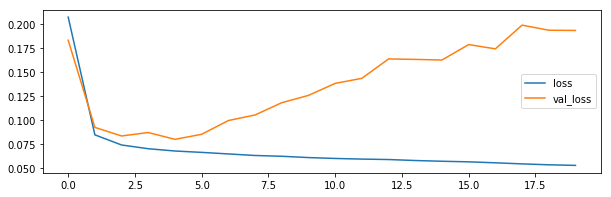

In [189]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(16,1)))
model.add(layers.Dense(64, activation='relu')) # single hidden layers
model.add(layers.Dense(16, activation='relu')) # single hidden layers
model.add(layers.Dense(23, activation='sigmoid')) # single hidden layers
model.add(layers.Dense(1, activation='linear')) # single hidden layers

model.compile(optimizer=RMSprop(), loss='mae')
    
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)
test_gen, num_test_steps = example_generator_factory.get_test_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=test_gen,
                              validation_steps=num_test_steps, verbose=False)

# you can use history to make plots of training and validation error
# after that you can make predictions with model.predict

plt.figure(figsize=(10,3))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

In [190]:
# Compared to the baseline:

import numpy as np

def evaluate_naive():
    batch_maes = []
    test, num_steps = example_generator_factory.get_test_gen(batchsize=20)
    for step in range(num_steps):
        X, y = next(test)
        yhat = np.mean(X, axis=1)
        mae = np.median(np.abs(y - yhat))
        batch_maes.append(mae)
    return batch_maes

naive_maes = evaluate_naive()
print(np.mean(naive_maes))
print(np.std(naive_maes))

0.344229535664377
0.0848321843037267


The deep neural net got down to a mae of ~ 0.050 which is significantly less than the baseline of 0.34. Neural net did better here on the test data set.